In [4]:
!pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/35/69/b657974ddcbba54d59d7d62b01e60a8b815e35f415b996e4d355be0ac7b4/opencv_python-4.9.0.80-cp37-abi3-macosx_10_16_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 MB 5.8 MB/s eta 0:00:0000:0100:01


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

Let's try read in an image!
[Alt text](dartboard-1.jpg)

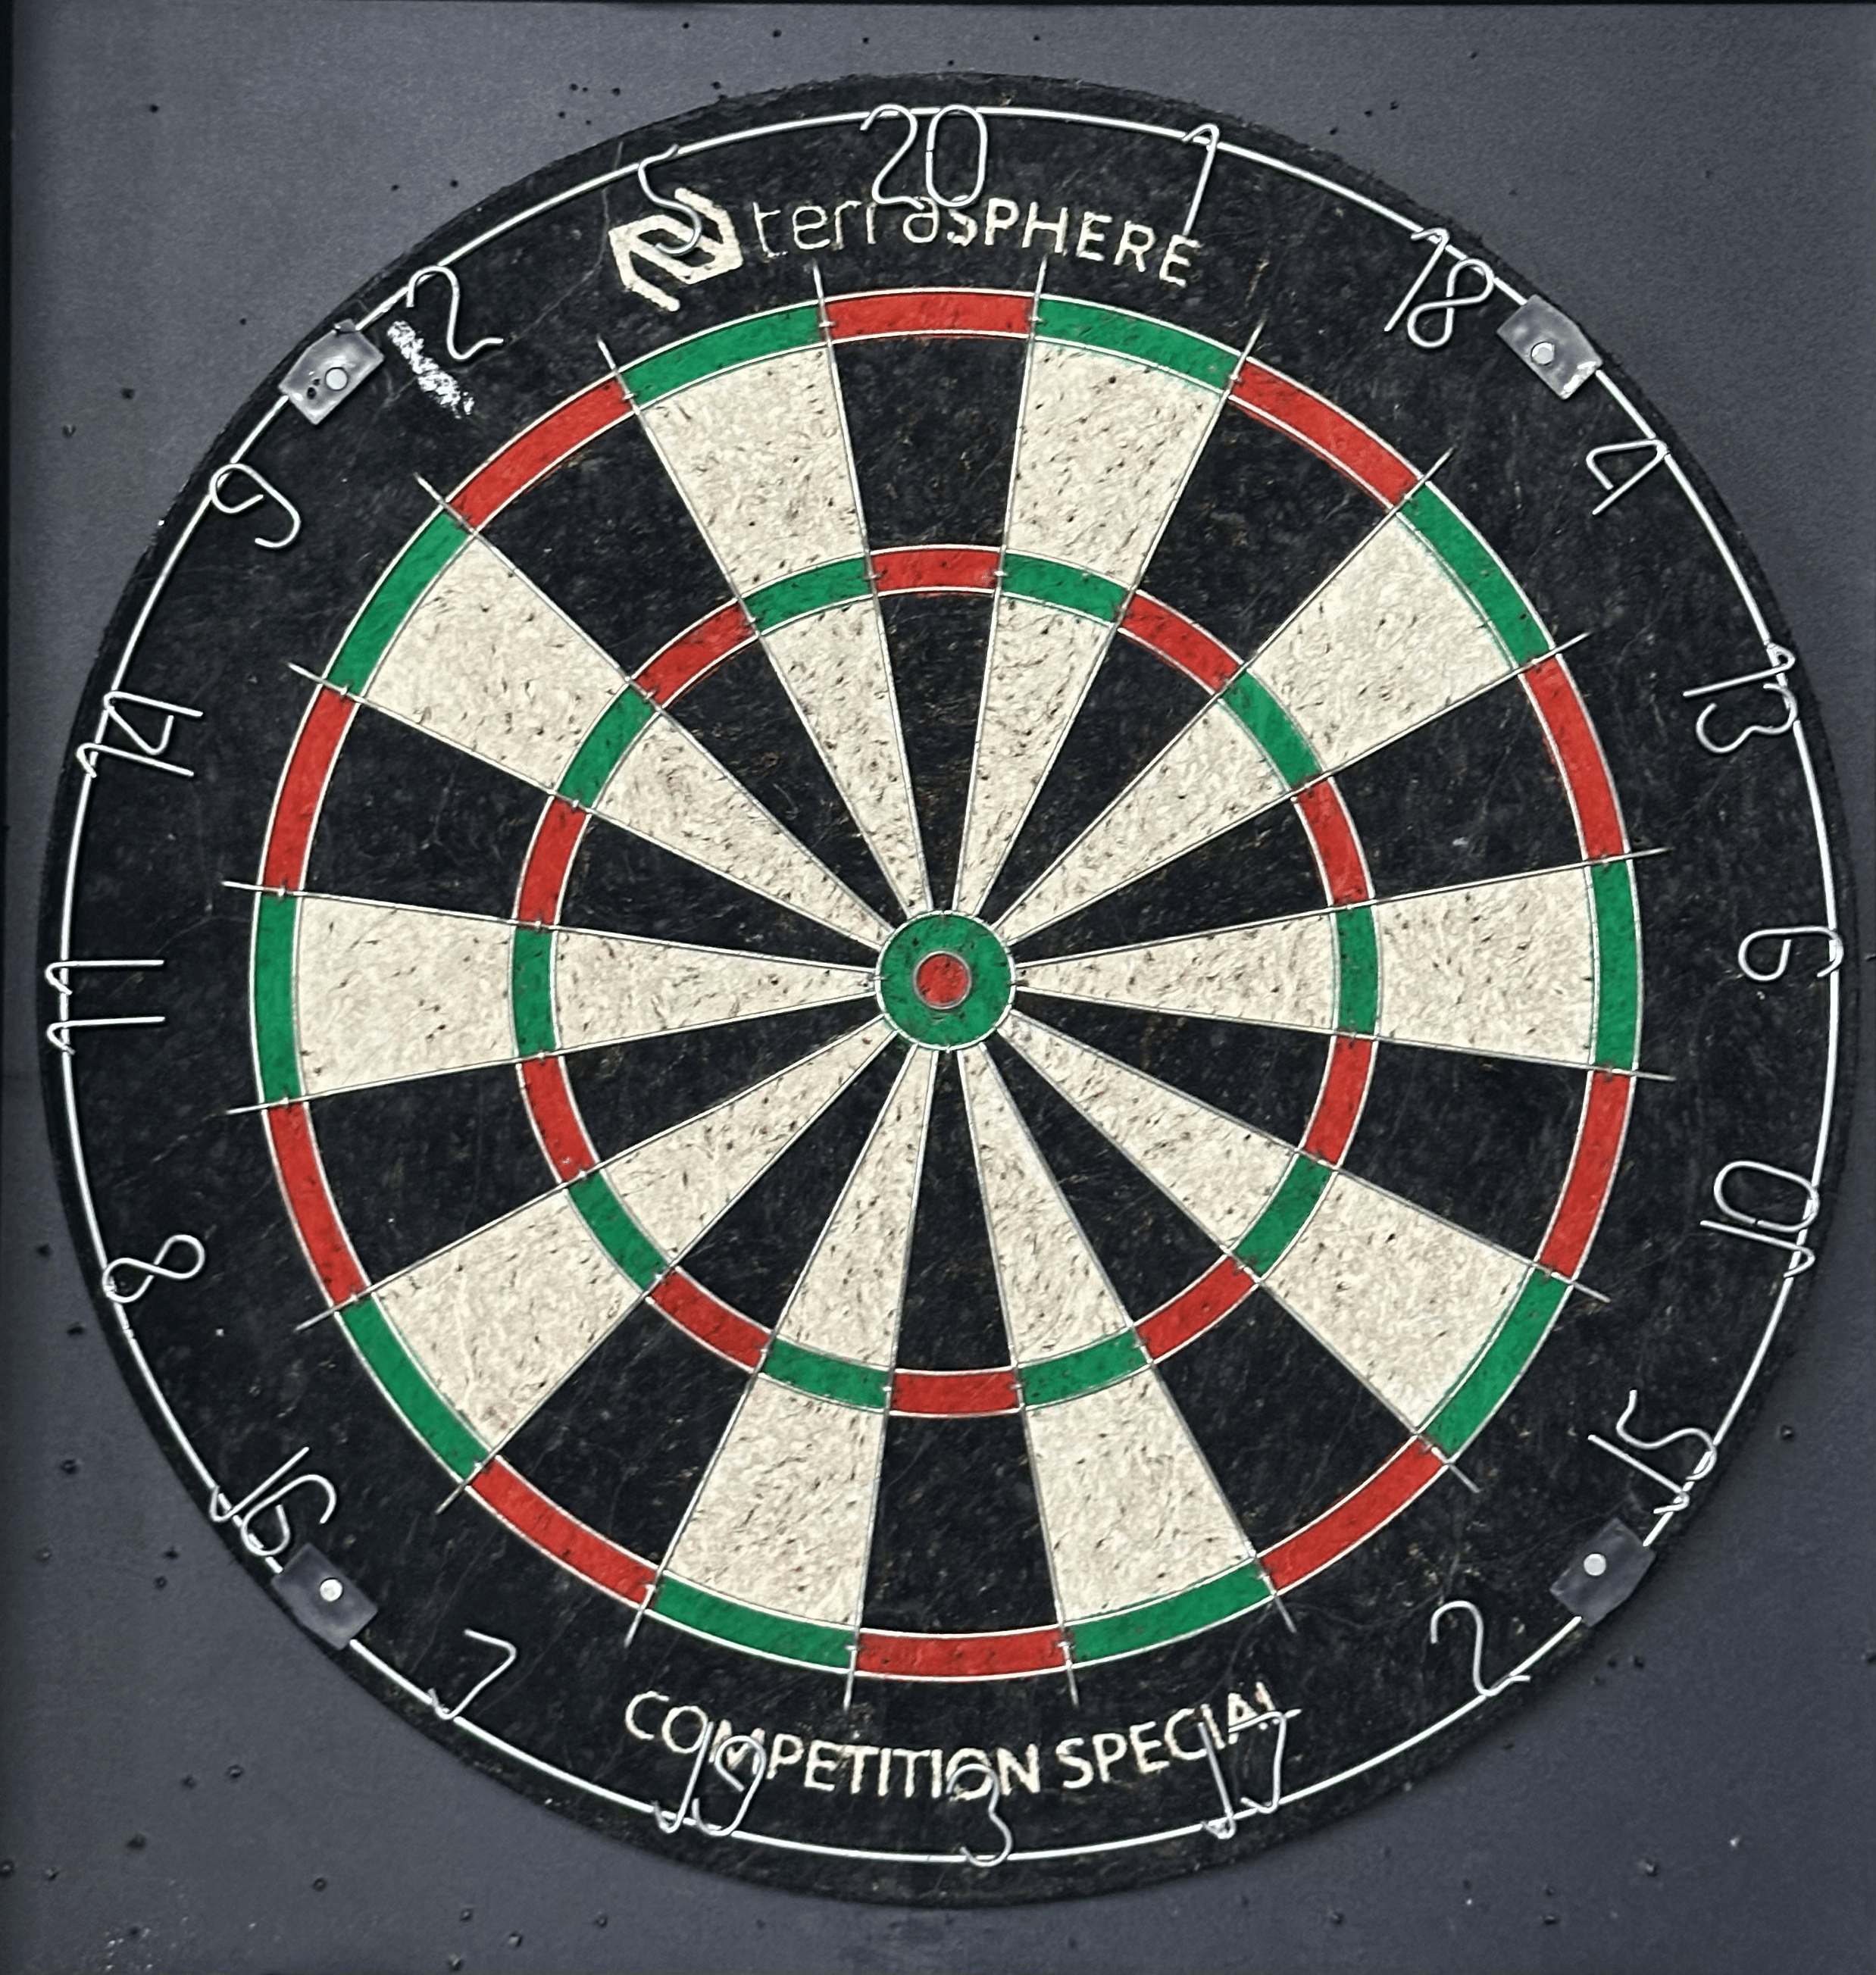

In [6]:
from IPython import display
display.Image("dartboard.png")

In [9]:
dart_img = cv2.imread("dartboard.png", 0)
print(dart_img)
print(dart_img.shape)
print(dart_img.dtype)

[[12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [16 16 16 ... 12 18 18]
 ...
 [47 48 48 ... 65 65 64]
 [47 50 50 ... 65 65 67]
 [49 49 49 ... 67 64 67]]
(2607, 2476)
uint8


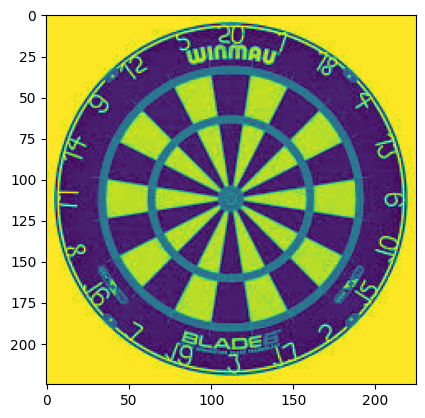

In [5]:
plt.imshow(dart_img)

Image alignment

In [10]:
dart_tilt_img = cv2.imread("real_dartboard.png", 0)

MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(dart_img, None)
keypoints2, descriptors2 = orb.detectAndCompute(dart_tilt_img, None)

dart_display = cv2.drawKeypoints(dart_img, keypoints1, outImage=np.array([]), color = (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
dart_tilt_display = cv2.drawKeypoints(dart_tilt_img, keypoints2, outImage=np.array([]), color = (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

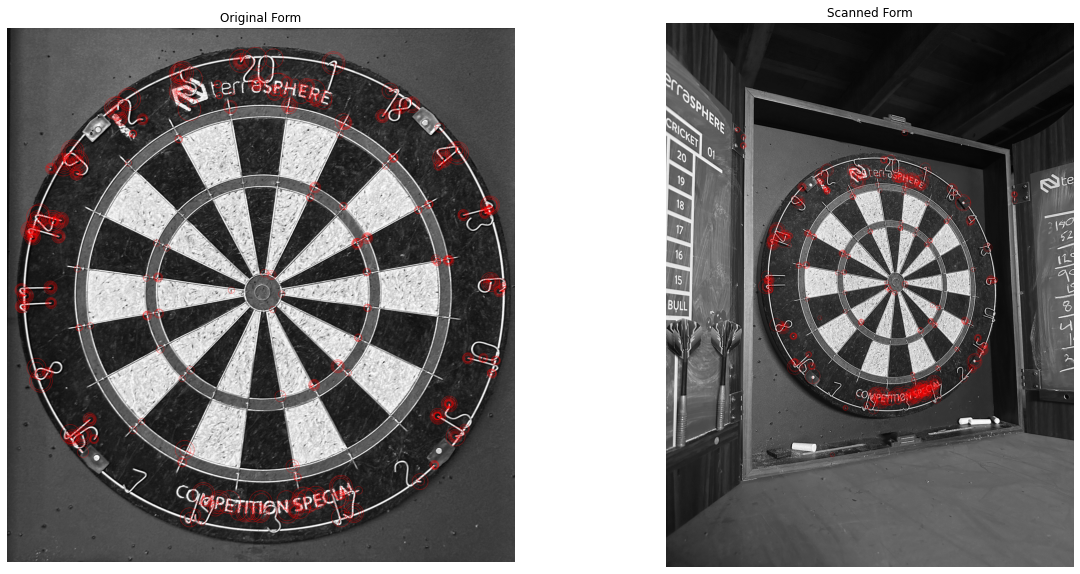

In [11]:
plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(dart_display); plt.title("Original Form");
plt.subplot(122); plt.axis('off'); plt.imshow(dart_tilt_display); plt.title("Scanned Form");

In [12]:
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# Converting to list for sorting as tuples are immutable objects.
matches = list(matcher.match(descriptors1, descriptors2, None))

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]

Text(0.5, 1.0, 'Original Form')

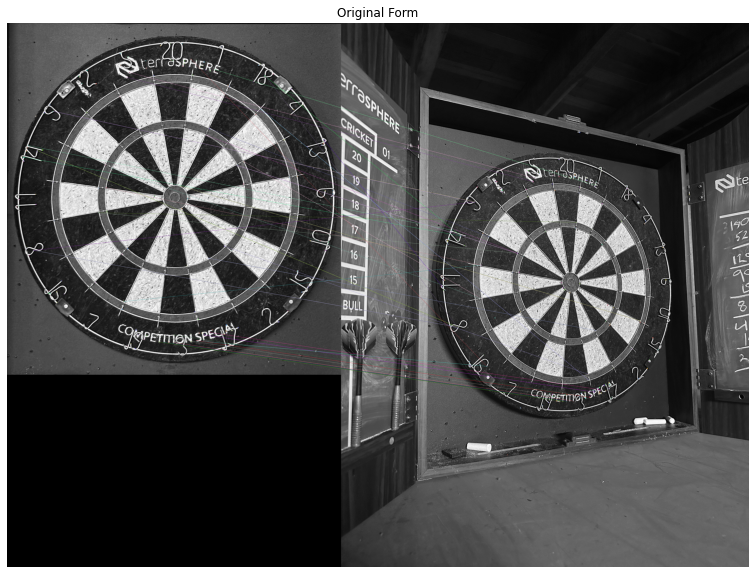

In [13]:
# Draw top matches
im_matches = cv2.drawMatches(dart_img, keypoints1, dart_tilt_img, keypoints2, matches, None)

plt.figure(figsize=[40, 10])
plt.imshow(im_matches);plt.axis("off");plt.title("Original Form")

In [14]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

[[ 9.85319756e-01 -1.11350456e-02 -6.47113326e+02]
 [-1.99510490e-01  1.03292352e+00 -5.94629457e+02]
 [-1.32286957e-04  1.86071692e-05  1.00000000e+00]]


Text(0.5, 1.0, 'Scanned Form')

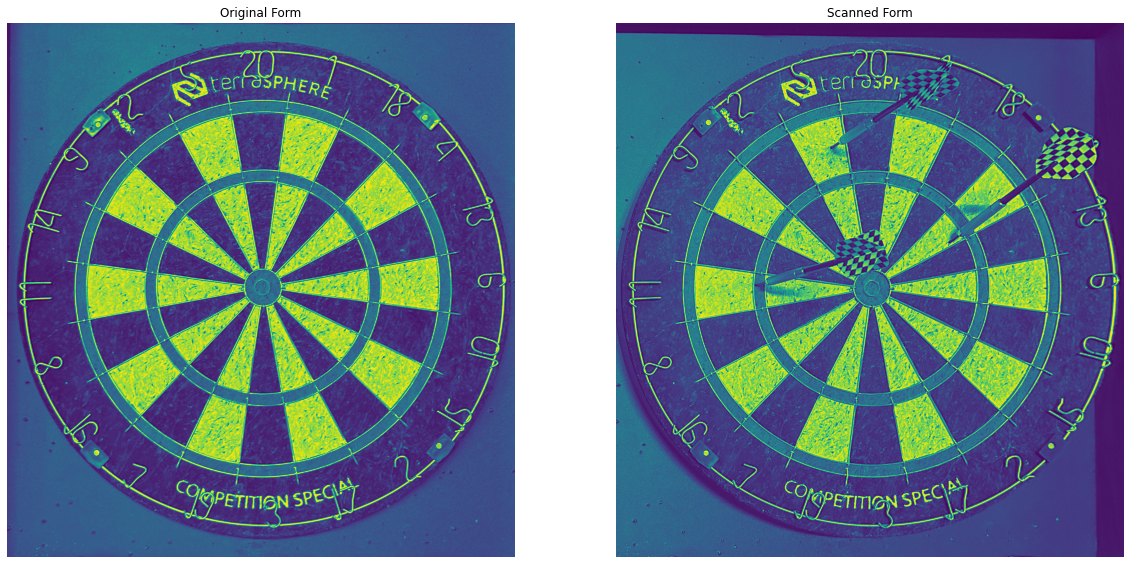

In [17]:
# Use homography to warp image
height, width = dart_img.shape
print(h)
realDart = cv2.imread("real_dartboard.png", 0)
dartReal2 = cv2.imread("example_dart-3.jpg", 0)
im2_reg = cv2.warpPerspective(dartReal2, h, (width, height))

# Display results
plt.figure(figsize=[20, 10])
plt.subplot(121);plt.imshow(dart_img);    plt.axis("off");plt.title("Original Form")
plt.subplot(122);plt.imshow(im2_reg);plt.axis("off");plt.title("Scanned Form")

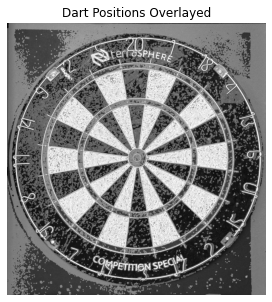

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Ensure 'dart_img' is in color
dart_img_color = cv2.cvtColor(dart_img, cv2.COLOR_GRAY2BGR)

# Ensure 'im2_reg' is in color
im2_reg_color = cv2.cvtColor(im2_reg, cv2.COLOR_GRAY2BGR)

# Compute absolute difference between the two images
difference = cv2.absdiff(dart_img_color, im2_reg_color)

# Convert the difference to grayscale
difference_gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)

# Threshold the difference to get a binary mask of the darts
_, mask = cv2.threshold(difference_gray, 30, 255, cv2.THRESH_BINARY)

# Dilate the mask to make the darts more visible
kernel = np.ones((5, 5), np.uint8)
mask_dilated = cv2.dilate(mask, kernel, iterations=2)

# Convert mask to a 3 channel image so it can be overlaid with color images
mask_colored = cv2.cvtColor(mask_dilated, cv2.COLOR_GRAY2BGR)

# Overlay the mask with darts on the original image with 30% opacity
alpha = 0.3
overlayed_img = cv2.addWeighted(dart_img_color, 1 - alpha, mask_colored, alpha, 0)

# Convert the overlayed image from BGR to RGB for displaying in matplotlib
overlayed_img_rgb = cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB)

# Display the result using matplotlib
plt.figure(figsize=[10, 5])
plt.imshow(overlayed_img_rgb)
plt.axis("off")
plt.title("Dart Positions Overlayed")
plt.show()


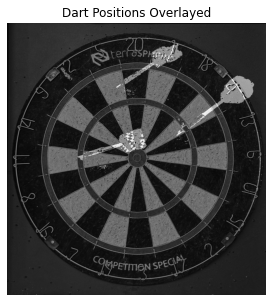

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the empty dartboard image and warp it using the previously computed homography 'h'
realDart = cv2.imread("real_dartboard.png", 0)
im1_reg = cv2.warpPerspective(realDart, h, (width, height))

# Load the image with darts and warp it using the same homography 'h'
dartReal2 = cv2.imread("example_dart-3.jpg", 0)
im2_reg = cv2.warpPerspective(dartReal2, h, (width, height))

# Adjust brightness and contrast to enhance the darts
# Convert images to float32 for brightness/contrast adjustment
im1_reg_float = im1_reg.astype(np.float32)
im2_reg_float = im2_reg.astype(np.float32)

# Apply histogram equalization to both images to improve contrast and reduce shadows
# im1_reg_histeq = cv2.equalizeHist(im1_reg)
# im2_reg_histeq = cv2.equalizeHist(im2_reg)

# Adjust brightness and contrast to enhance the darts
alpha = 3.0  # Contrast control (1.0-3.0)
beta = 10  # Brightness control (0-100)
im1_reg_enhanced = cv2.convertScaleAbs(im1_reg, alpha=alpha, beta=beta)
im2_reg_enhanced = cv2.convertScaleAbs(im2_reg, alpha=alpha, beta=beta)

# Compute absolute difference between the two enhanced images
difference = cv2.absdiff(im1_reg_enhanced, im2_reg_enhanced)

# Threshold the difference to get a binary mask of the darts
_, mask = cv2.threshold(difference, 30, 255, cv2.THRESH_BINARY)

# Optional: apply morphological operations to clean up the mask
kernel = np.ones((3, 3), np.uint8)
mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)

# Convert mask to a 3 channel image so it can be overlaid with color images
mask_colored = cv2.cvtColor(mask_cleaned, cv2.COLOR_GRAY2BGR)

# Ensure 'dart_img' is in color
dart_img_color = cv2.cvtColor(dart_img, cv2.COLOR_GRAY2BGR) if len(dart_img.shape) == 2 else dart_img

# Overlay the mask with darts on the original image with 30% opacity
alpha = 0.5
overlayed_img = cv2.addWeighted(dart_img_color, 1 - alpha, mask_colored, alpha, 0)

# Convert the overlayed image from BGR to RGB for displaying in matplotlib
overlayed_img_rgb = cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB)

# Display the result using matplotlib
plt.figure(figsize=[10, 5])
plt.imshow(overlayed_img_rgb)
plt.axis("off")
plt.title("Dart Positions Overlayed")
plt.show()


----------------------------------------------------------------------

In [ ]:
dart_img = cv2.imread("real_dartboard.png", 0)
gray_blur = cv2.GaussianBlur(dart_tilt_img, (31,31), 0)
circles = cv2.HoughCircles(gray_blur, cv2.HOUGH_GRADIENT, 1, 20,
                           param1=50, param2=30, minRadius=0, maxRadius=0)


if circles is not None:
    circles = np.uint16(np.around(circles))
    print(circles)
    for i in circles[0, :]:
        center = (i[0], i[1])  # x, y of the dartboard's center
        radius = i[2]
        # Draw the outer circle
        cv2.circle(dart_img, center, radius, (0, 255, 0), 2)
        # Draw the center of the circle
        cv2.circle(dart_img, center, 2, (0, 0, 255), 3)
        break  # Assuming the first circle detected is the dartboard for simplicity


# Display the result
cv2.imshow('Detected Circles', dart_img)
cv2.waitKey(0)

: 